In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr, spearmanr, kendalltau
from glob import glob

In [30]:
def _get_instance_level_correlation(data: pd.DataFrame, metrics: list, target_col: str, corr_method: callable) -> dict:
    name = corr_method.__name__
    print("Computing", name, "with", target_col, "col")
    
    # Pseudo algorithm
    # 1. Iterate over each doc_id
    # 2. Compute the correlation between different metric values for each doc_id and the human values
    # 3. Avg correlation coefficients in the end
    instance_level_corrs = defaultdict(list)

    for iid in data["bartscore_doc_id"].unique():
        for m in metrics:
            instance = data[data["bartscore_doc_id"] == iid]
            corr, p_val = corr_method(instance[m], instance[target_col])
            instance_level_corrs[m].append(corr)
           
    # Compute the avg (#TODO - handle p_val)
    instance_level_corrs_avg = {metric: np.mean(corr_data) for metric, corr_data in instance_level_corrs.items()}
    return instance_level_corrs_avg


def compute_instance_level_correlations(data, metrics, target_col, dataset_name, output_dir, to_persist=True, **_):
    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_instance_level_correlation(data, metrics, target_col, corr_method)

        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_instance_corrs.csv", index=0)
    
    return correlations


def _get_system_level_correlation(data, metrics, target_col, systems, corr_method: callable) -> dict:
    # pseudo code
    # for each system
    # compute the mean score attributed by a metric m to the outputs of each system.
    # compute the mean score attributed by a target_col to the outputs of each system.
    # compute correlation
    system_level_correlation = defaultdict(list)
    for sys in systems:
        data_sys = data[data["sys_name"] == sys]
        # ^Note: since we're computing the mean, we dont need to ensure the ordering

        for m in metrics + [target_col]:
            mean_sys = data_sys[m].mean()
            system_level_correlation[m].append(mean_sys)

    # Compute the correlation now
    correlations = {}
    for m in metrics:
        corr, p_val = corr_method(system_level_correlation[m], system_level_correlation[target_col])

        correlations[m] = round(corr, 4)

    return correlations


def compute_system_level_correlations(data, metrics, target_col, dataset_name, systems, output_dir, to_persist=True, **_):

    correlations = {}
    for corr_method in (pearsonr, spearmanr, kendalltau):
        result = _get_system_level_correlation(data, metrics, target_col, systems, corr_method)
        correlations[corr_method.__name__] = result

    correlations = pd.DataFrame(correlations)
    if to_persist:
        os.makedirs(output_dir, exist_ok=True)
        correlations.reset_index().to_csv(f"{output_dir}/{dataset_name}_system_corrs.csv", index=0)
    
    return correlations

In [31]:
TARGET_COL = "target"
DATASET_NAME = "realsumm"
DATASET_DIR = "../datasets/summ_data/REALSumm/quantile/regression"

dfs = []
for split in ("all", "train", "dev", "test"):
    df = pd.read_csv(f"{DATASET_DIR}/{split}.csv")
    for col in ("bert_score_p", "bert_score_r", "bert_score_f"):
        if col in df.columns:
            df[col] = df[col].apply(lambda s: s.replace("tensor", "")[1:-1]).apply(float)

    dfs.append(df)
    
all_df, train_df, dev_df, test_df = dfs

<AxesSubplot:xlabel='target', ylabel='Count'>

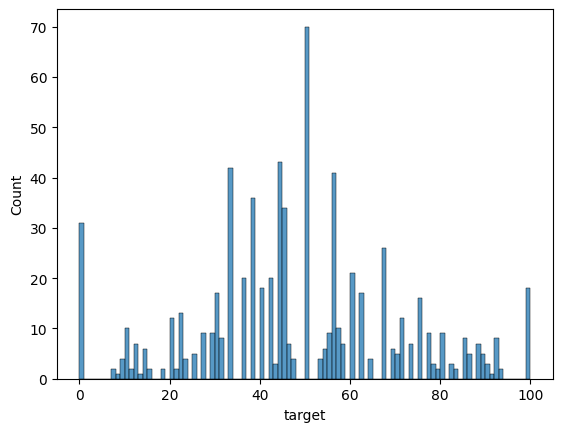

In [46]:
sns.histplot(data=dev_df, x="target", bins=100, binrange=(0, 100))

In [32]:
METRICS = [
    # BERTScore
    'bert_score_p','bert_score_r','bert_score_f',
    'mover_score',
    # PRISM
    'prism_ref_hypo','prism_hypo_ref','prism_avg','prism_src_hypo',
    # ROUGE
    'rouge1_r','rouge1_p','rouge1_f',
    'rouge2_r','rouge2_p','rouge2_f',
    'rougel_r','rougel_p','rougel_f',
    # BARTScore
    'bart_score_cnn_ref_hypo_en', 'bart_score_cnn_ref_hypo_de',
    'bart_score_cnn_hypo_ref_en','bart_score_cnn_hypo_ref_de',
    'bart_score_cnn_avg_f_en','bart_score_cnn_avg_f_de',
    'bart_score_cnn_harm_f_en','bart_score_cnn_harm_f_de',
    'bart_score_src_hypo','bart_score_hypo_ref','bart_score_ref_hypo','bart_score_avg_f','bart_score_harm_f',
    'bart_score_cnn_src_hypo','bart_score_cnn_hypo_ref','bart_score_cnn_ref_hypo','bart_score_cnn_avg_f','bart_score_cnn_harm_f',
    'bart_score_para_src_hypo','bart_score_para_hypo_ref','bart_score_para_ref_hypo','bart_score_para_avg_f','bart_score_para_harm_f',
]
systems = sorted(all_df["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
print("-" * 80)
print("Computing correlations for AUTOMATED METRICS")
print("-" * 80)

instance_corr_metrics = compute_instance_level_correlations(
    dev_df,
    metrics=METRICS,
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    to_persist=False,
)

system_corr_metrics = compute_system_level_correlations(
    dev_df, 
    metrics=METRICS,
    target_col=TARGET_COL,
    dataset_name=f"{DATASET_NAME.lower()}",
    output_dir="",
    systems=systems,
    to_persist=False
)

--------------------------------------------------------------------------------
Computing correlations for AUTOMATED METRICS
--------------------------------------------------------------------------------
Computing pearsonr with target col
Computing spearmanr with target col
Computing kendalltau with target col


In [33]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau
rougel_r,0.553740,0.505894,0.423369
rouge1_r,0.562514,0.505624,0.419421
rouge2_r,0.494576,0.458883,0.381636
bart_score_cnn_hypo_ref_de,0.519002,0.476184,0.380127
bart_score_cnn_hypo_ref,0.514822,0.464792,0.367670


<AxesSubplot:>

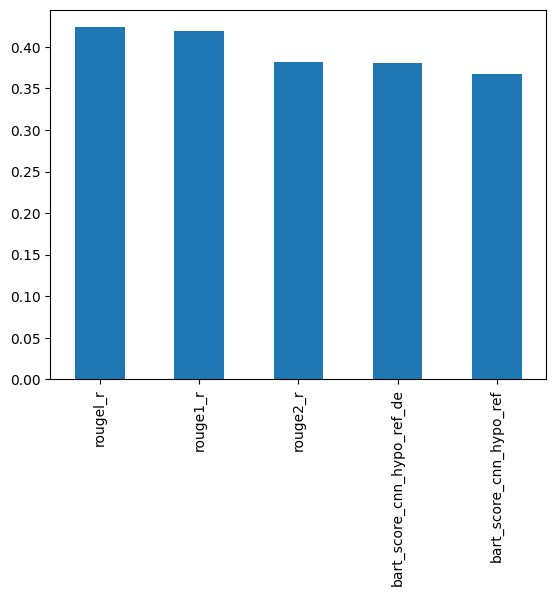

In [34]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

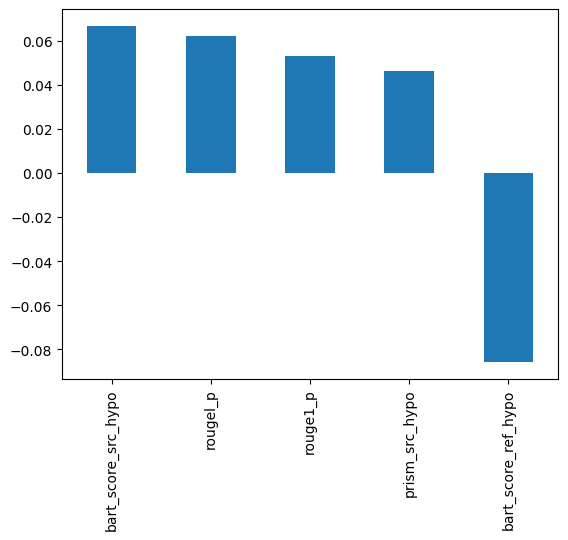

In [35]:
instance_corr_metrics.sort_values("kendalltau", ascending=False).tail()["kendalltau"].plot(kind="bar")

In [36]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau
rouge1_r,0.7892,0.8493,0.6860
rouge2_r,0.8434,0.8271,0.6715
rougel_r,0.7990,0.8384,0.6497
bart_score_para_hypo_ref,0.8170,0.7771,0.5917
bart_score_cnn_hypo_ref,0.7867,0.8010,0.5917


<AxesSubplot:>

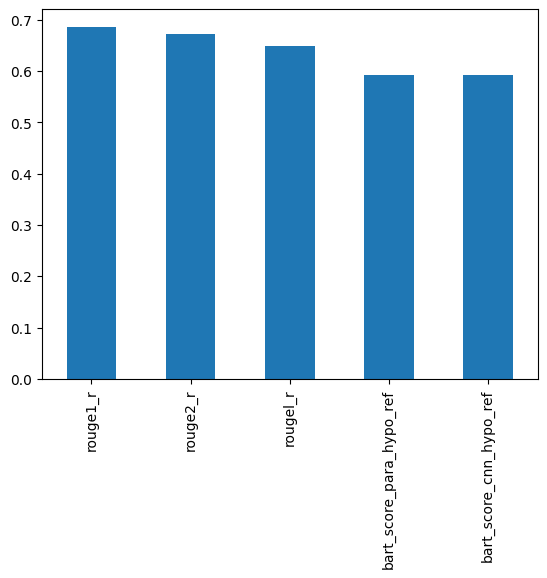

In [37]:
system_corr_metrics.sort_values("kendalltau", ascending=False).head()["kendalltau"].plot(kind="bar")

<AxesSubplot:>

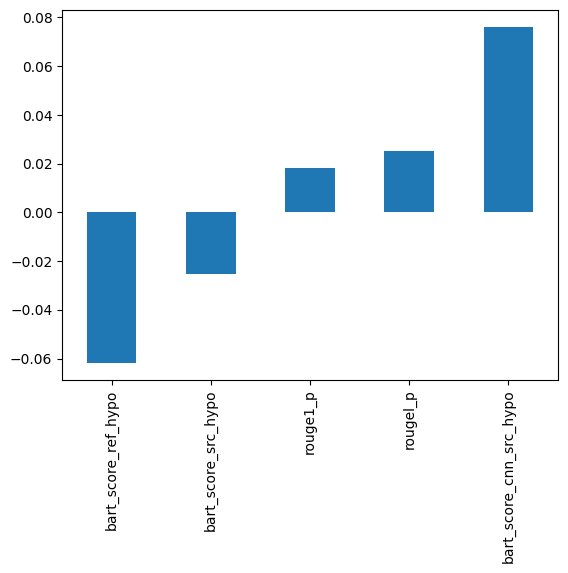

In [38]:
system_corr_metrics.sort_values("kendalltau").head()["kendalltau"].plot(kind="bar")

In [39]:
def compute_metrics(df: pd.DataFrame):
    from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
    from scipy.stats import pearsonr, spearmanr, kendalltau
    
    metrics = {}
    
    num_correct = 0
    num_digits = 0
    errs_p, errs_t, errs, mae, mse = [], [], [], [], []
    for p, t in zip(df["prediction"], df["label"]):
        # label is already a number
        p = str(p) if isinstance(p, (int, float)) else p
        p = p.strip()

        num_correct += (p == str(t))
        num_digits += p.isdigit()

        if not p.isdigit():
            continue

        p, t = float(p), float(t)
        err = (t - p)
        errs_p.append(p)
        errs_t.append(t)
        errs.append(err)
        mae.append(np.abs(err))
        mse.append(err * err)
    
    metrics["accuracy"] = num_correct / len(df)
    metrics["digits_count"] = num_digits
    metrics["digits_pct"] = num_digits / len(df)

    metrics["err_len"] = len(errs)
    metrics["err_avg"] = float(np.mean(errs))
    metrics["mae_avg"] = float(np.mean(mae))
    metrics["mse_avg"] = float(np.mean(mse))

    metrics["err_std"] = float(np.std(errs))
    metrics["mae_std"] = float(np.std(mae))
    metrics["mse_std"] = float(np.std(mse))
    
    return metrics

Find 45 experiments



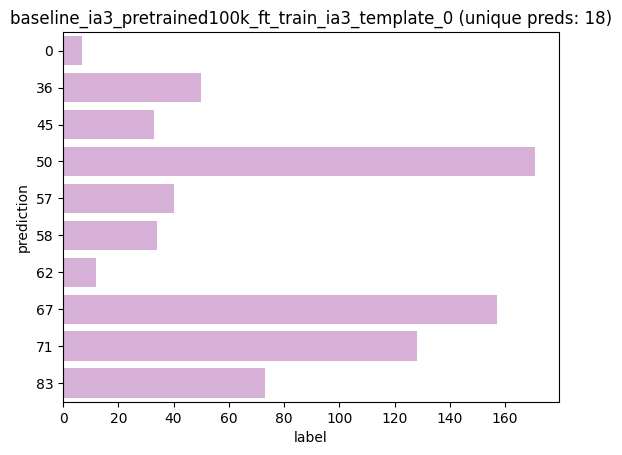

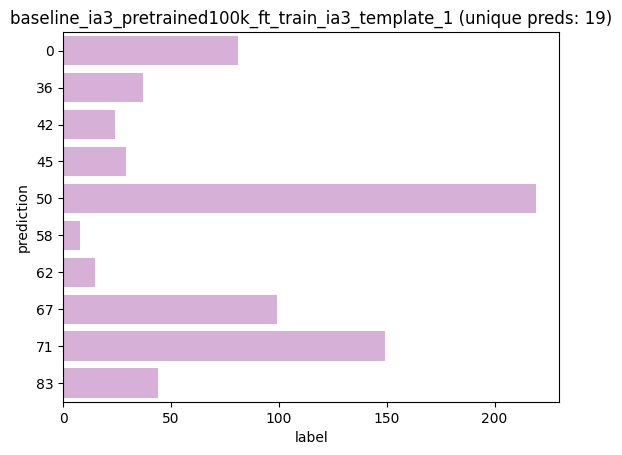

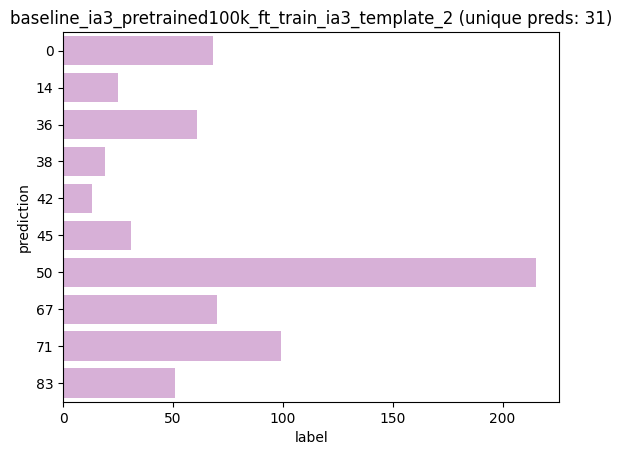

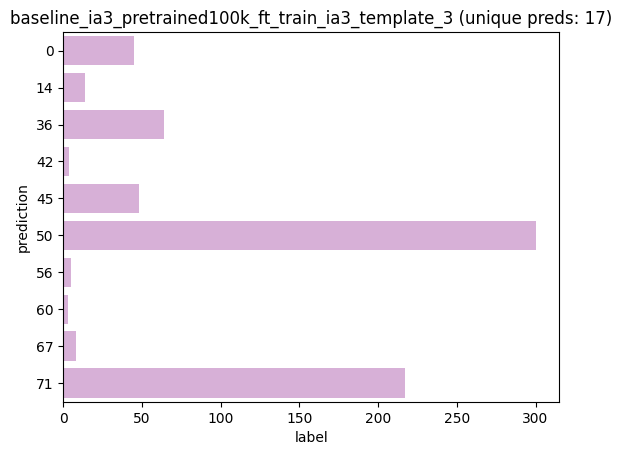

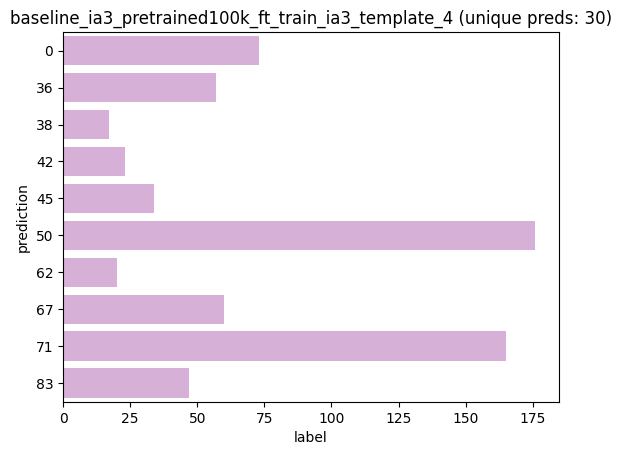

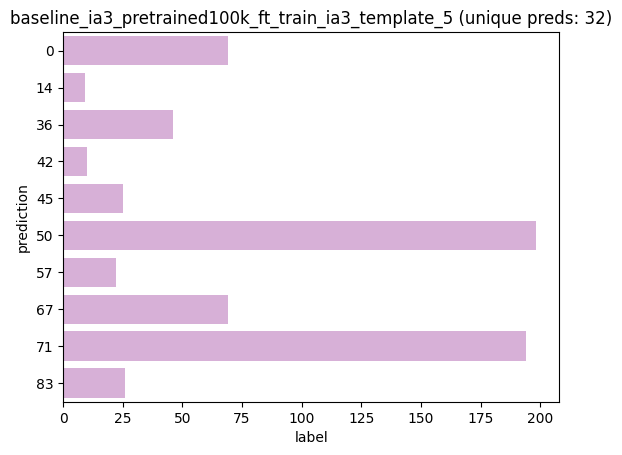

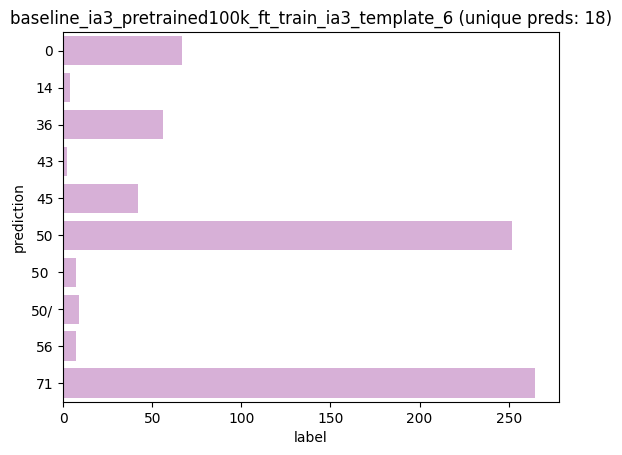

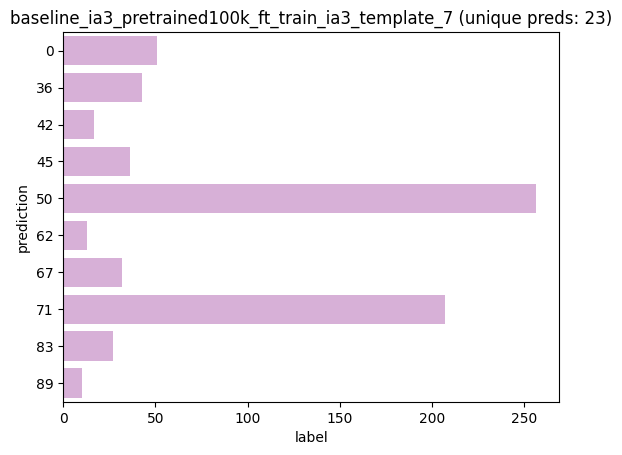

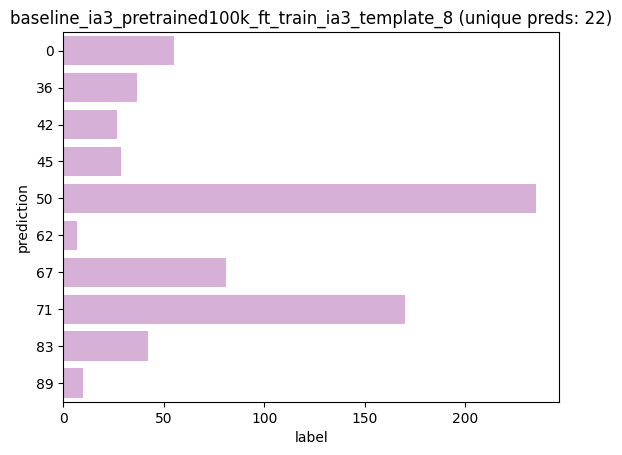

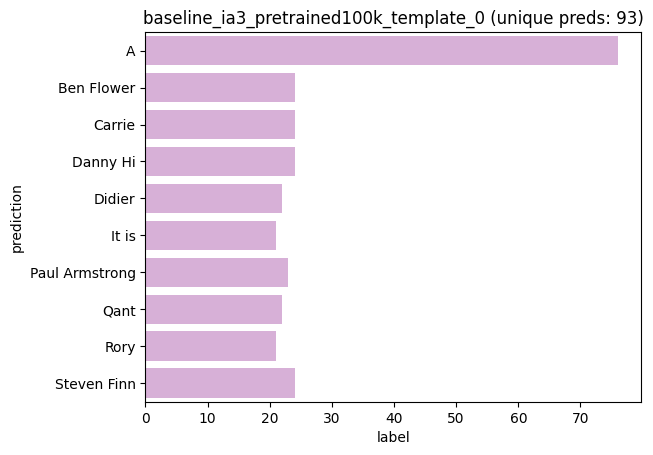

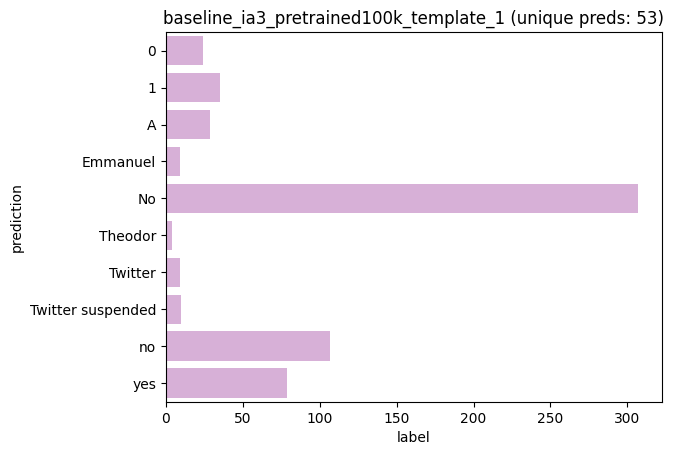

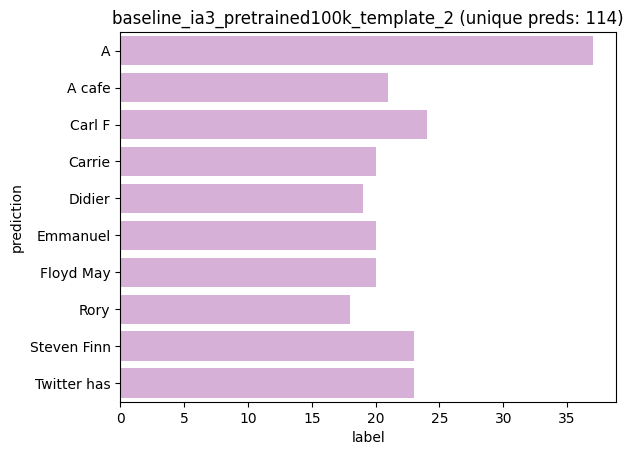

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


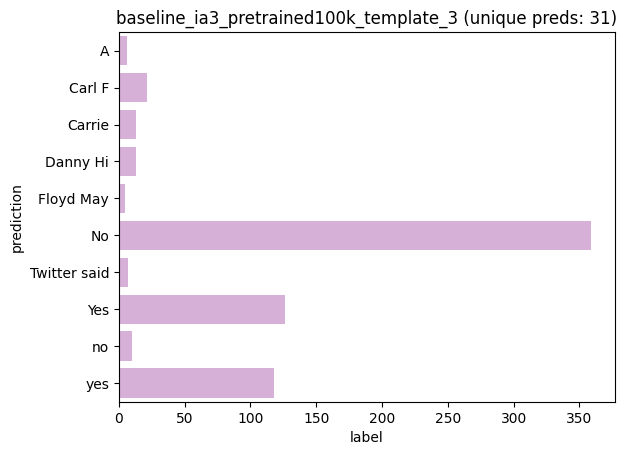

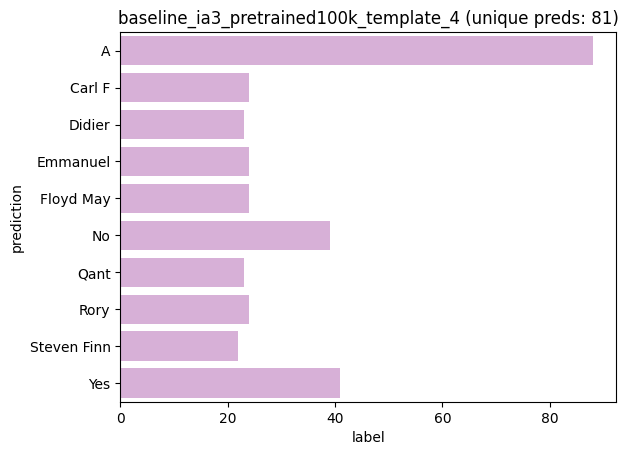

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


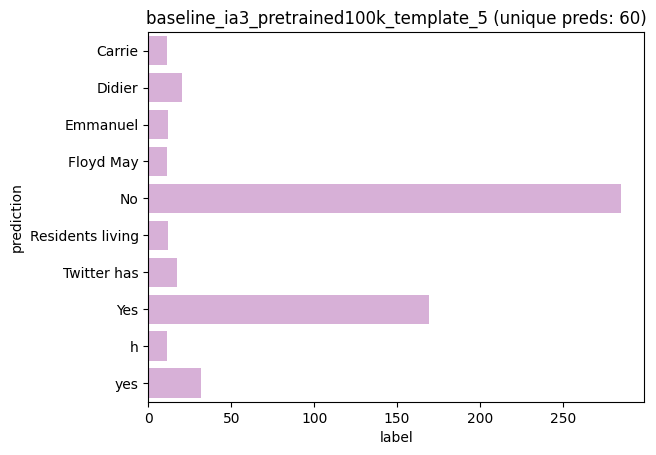

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


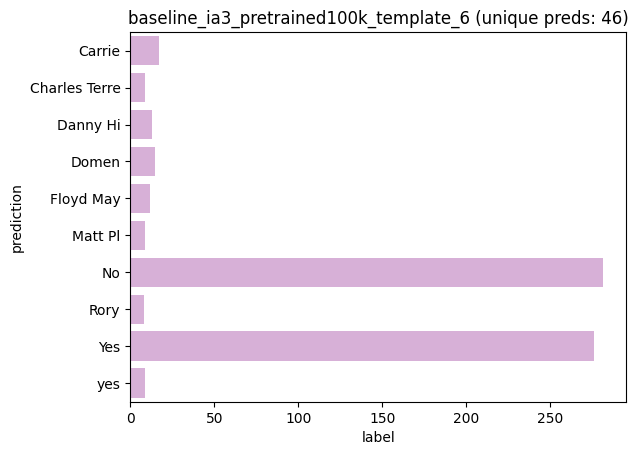

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


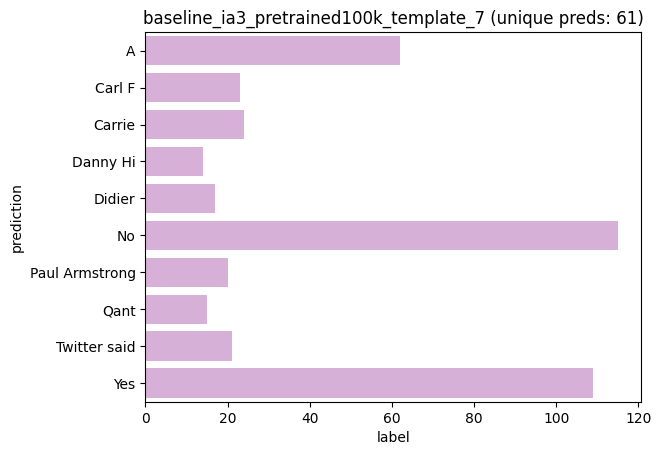

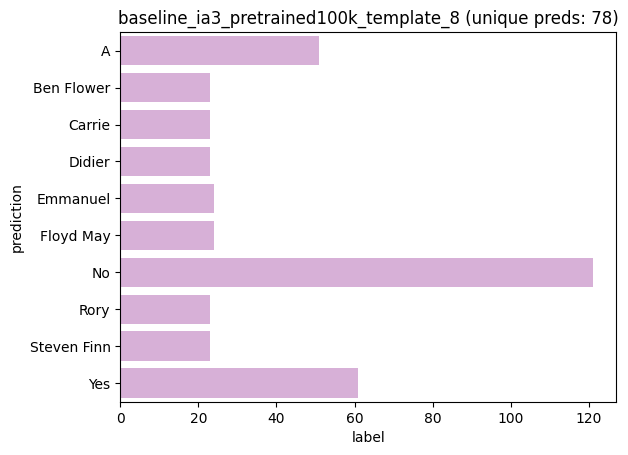

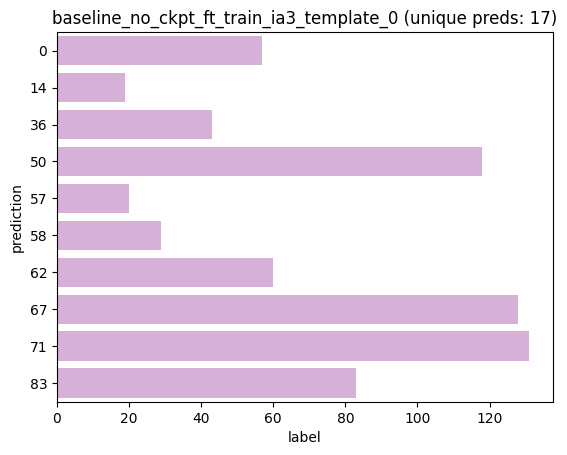

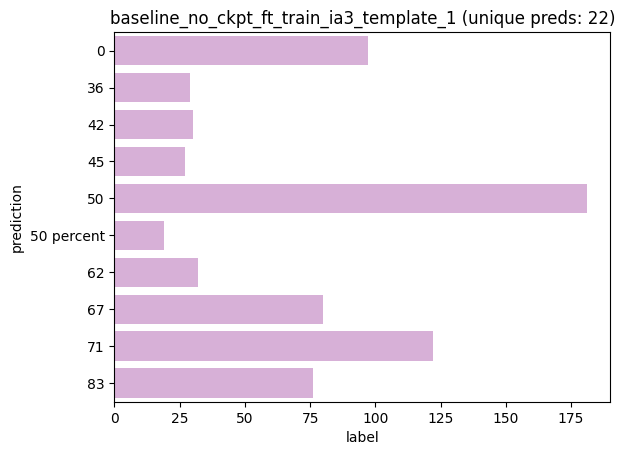

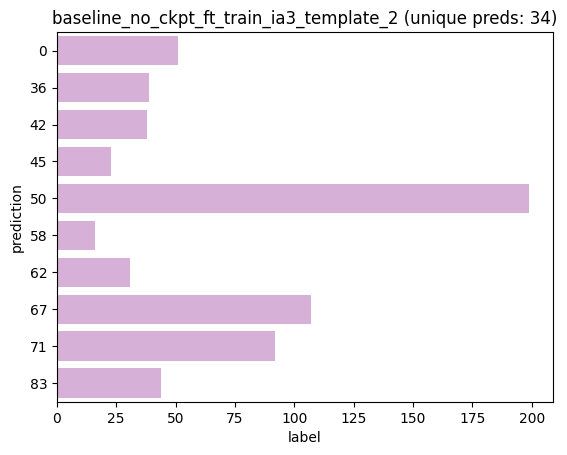

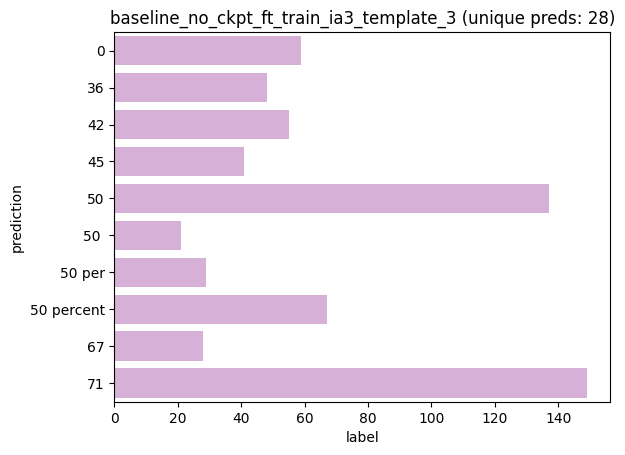

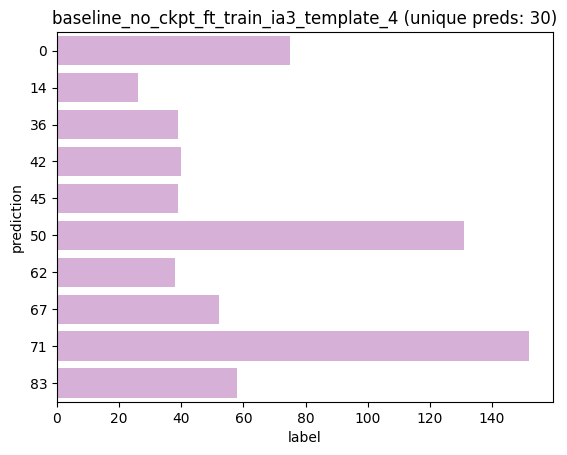

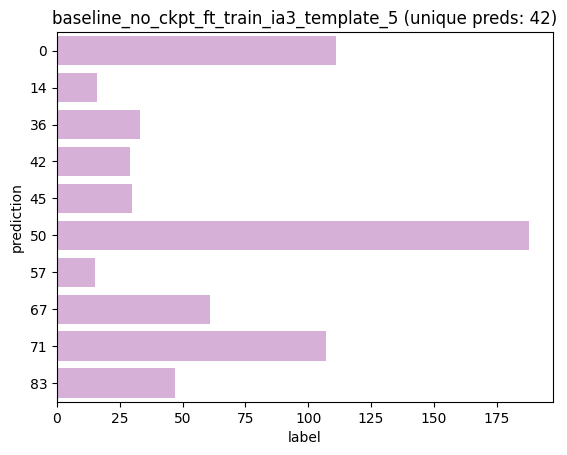

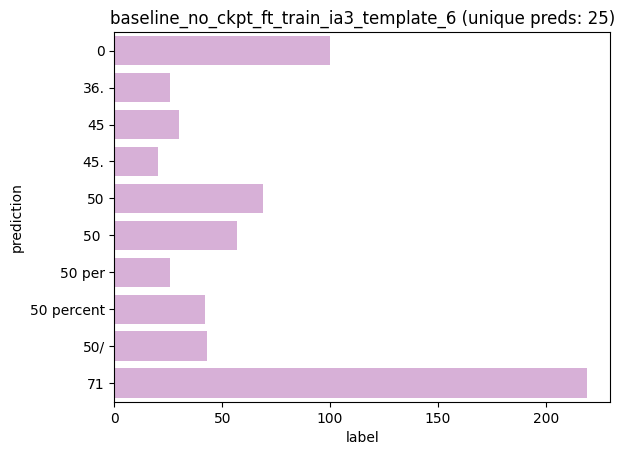

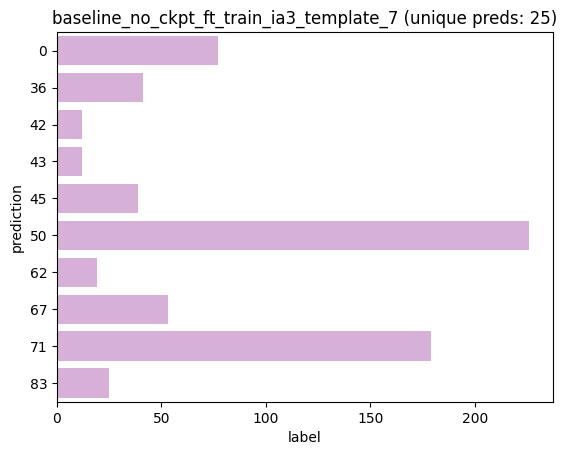

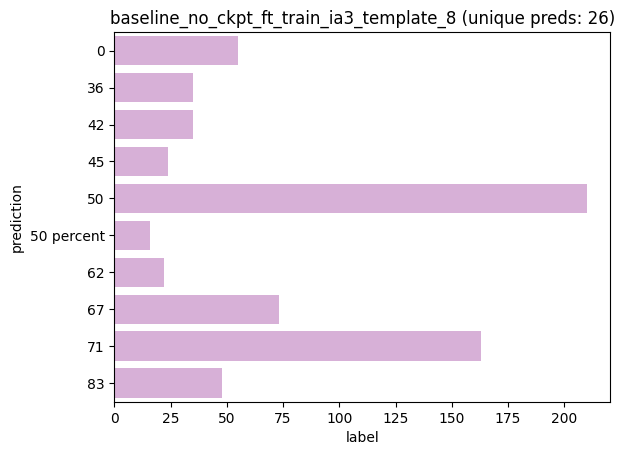

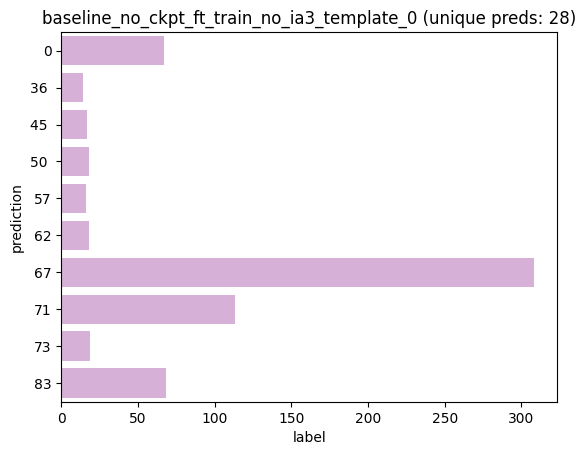

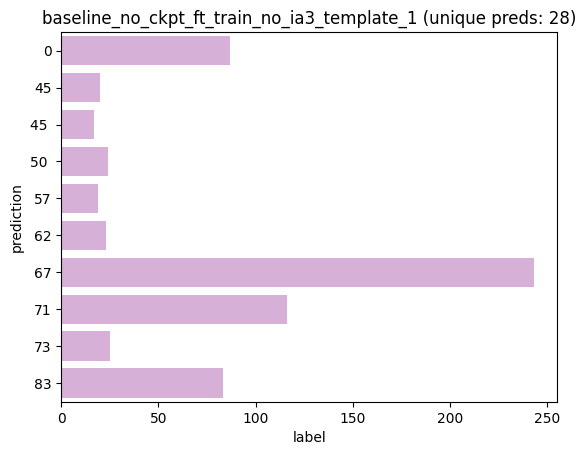

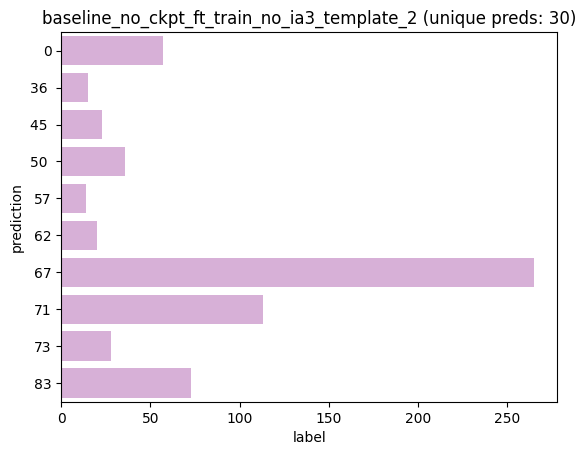

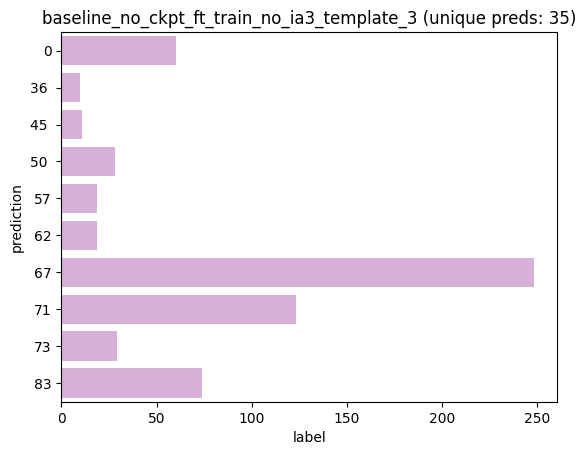

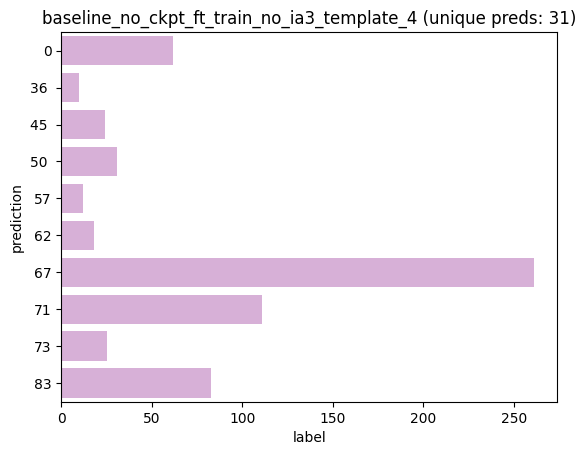

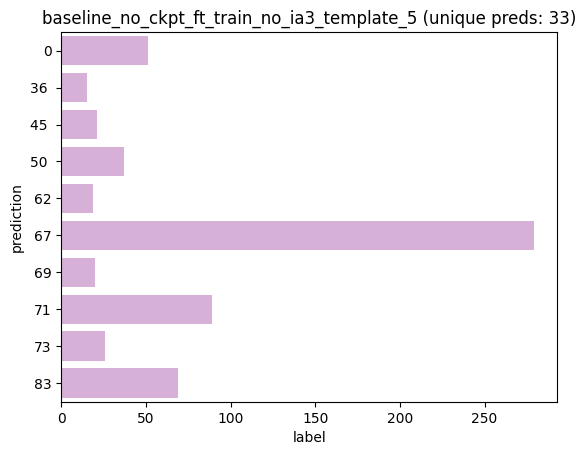

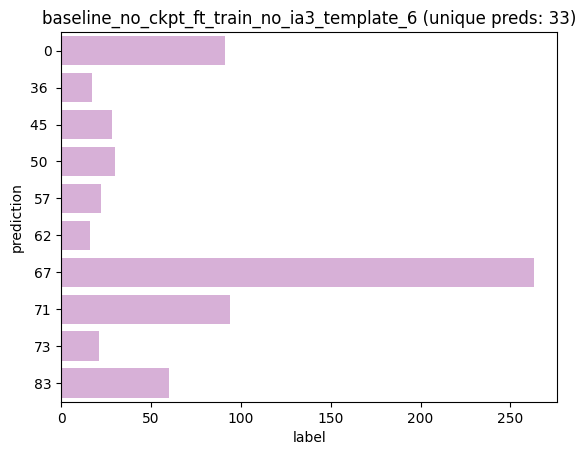

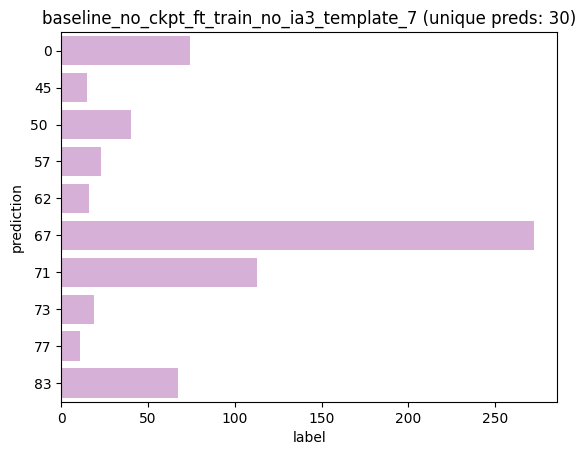

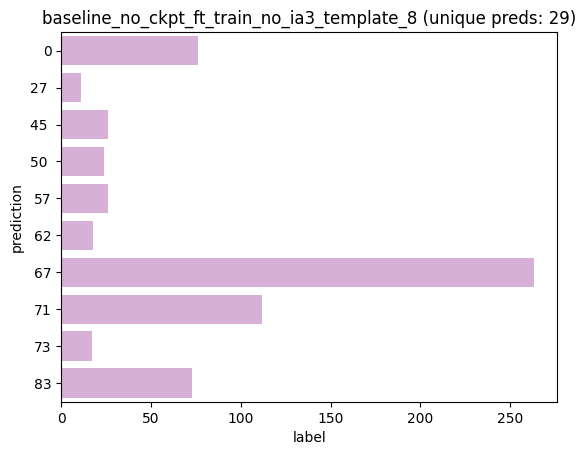

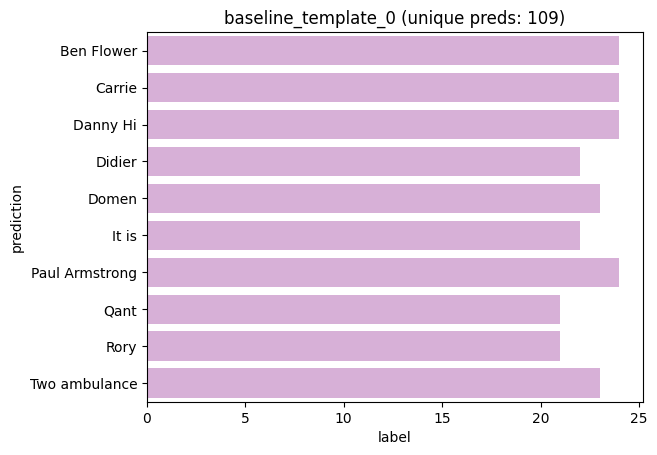

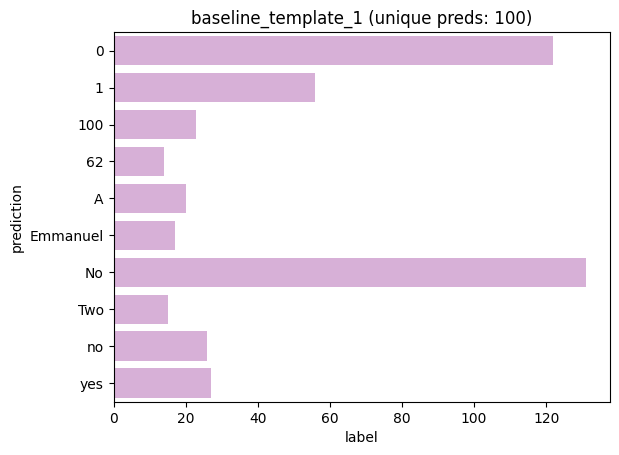

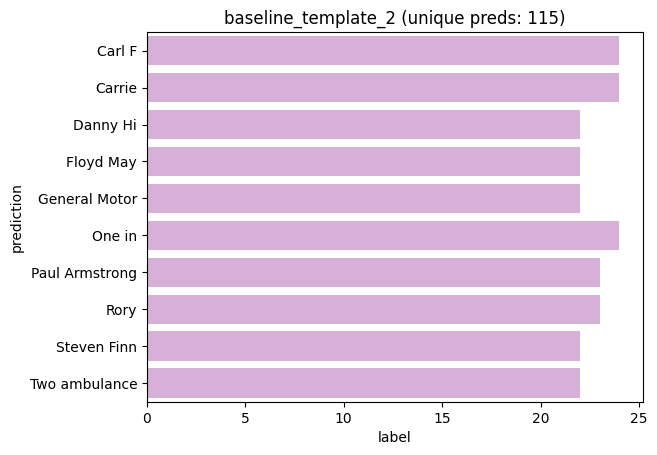

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


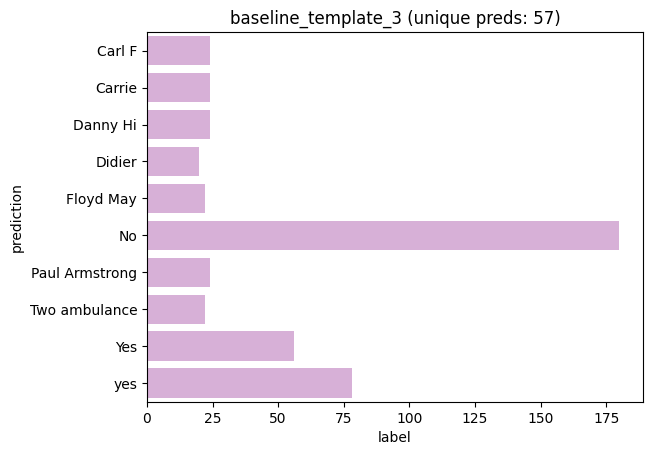

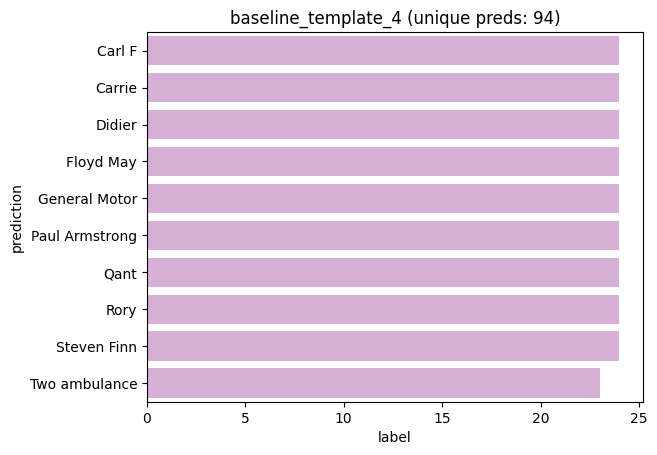

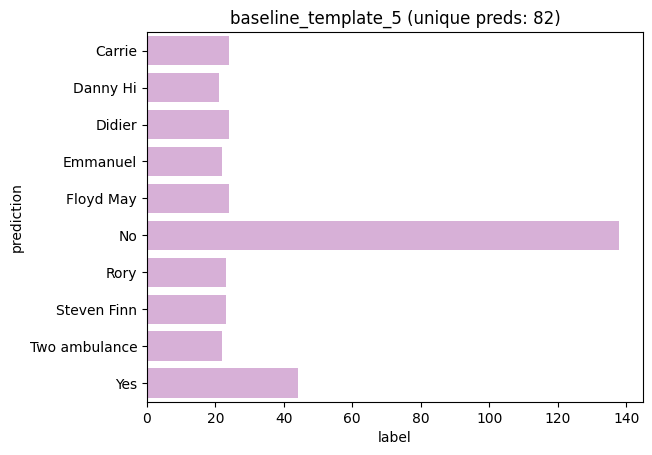

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


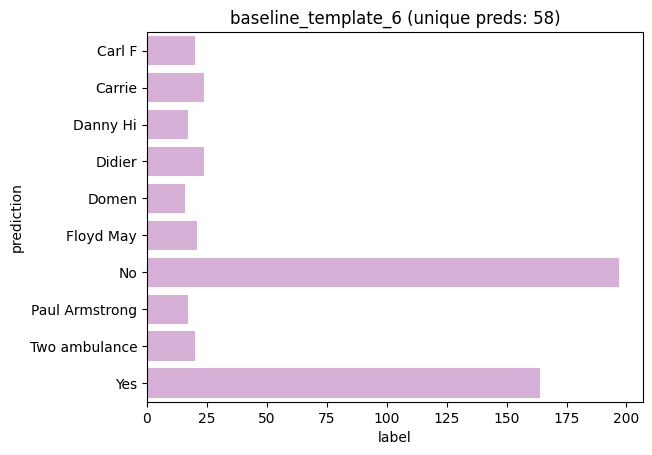

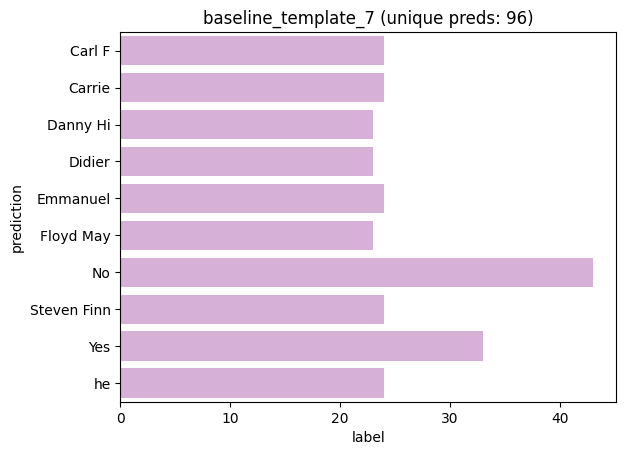

/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cbelem/miniconda3/envs/mm-env-2/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


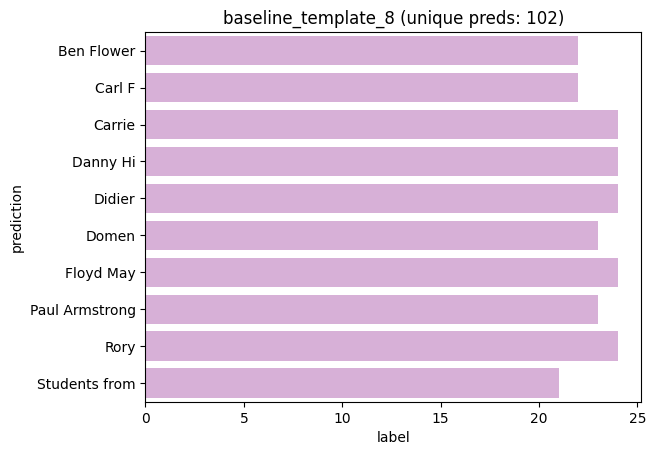

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline
0,0.030556,720,1.000000,720,-12.055556,24.463889,864.458333,26.816449,16.308785,1026.638048,baseline_ia3_pretrained100k_ft_train_ia3_templ...
1,0.038889,715,0.993056,715,-4.306294,25.327273,960.966434,30.698897,17.874442,1263.049416,baseline_ia3_pretrained100k_ft_train_ia3_templ...
2,0.048611,706,0.980556,706,-1.903683,23.702550,865.512748,29.357942,17.427045,1136.237128,baseline_ia3_pretrained100k_ft_train_ia3_templ...
3,0.050000,716,0.994444,716,-3.462291,22.822626,798.093575,28.037584,16.649965,1045.841086,baseline_ia3_pretrained100k_ft_train_ia3_templ...
4,0.033333,705,0.979167,705,-4.297872,25.109220,951.063830,30.538371,17.905053,1248.677881,baseline_ia3_pretrained100k_ft_train_ia3_templ...
5,0.033333,692,0.961111,692,-5.319364,24.880058,921.238439,29.882149,17.384509,1176.190839,baseline_ia3_pretrained100k_ft_train_ia3_templ...
6,0.048611,705,0.979167,705,-3.940426,24.153191,857.577305,29.018104,16.559005,1042.718984,baseline_ia3_pretrained100k_ft_train_ia3_templ...
7,0.037500,714,0.991667,714,-6.032213,24.682073,900.920168,29.402935,17.079679,1134.872653,baseline_ia3_pretrained100k_ft_train_ia3_templ...
8,0.031944,717,0.995833,717,-6.500697,25.543933,944.832636,30.042862,17.097957,1107.812775,baseline_ia3_pretrained100k_ft_train_ia3_templ...
9,0.000000,18,0.025000,18,-5.777778,33.000000,1333.777778,36.060991,15.645376,1207.389174,baseline_ia3_pretrained100k_template_0


In [98]:
output_dir = f"../t-few-master/experiments_balanced/realsumm_reg/evals"
dev_files = sorted(glob(os.path.join(output_dir, "*", "dev_pred.txt")))
print(f"Find {len(dev_files)} experiments")
print()

def extract_name(path):
    # Given a path in the format
    # './t-few-master/exp_out/realsumm/t03b_realsumm_baseline_ft_train/<something>
    # 1. Extract the parent dir `t03b_realsumm_baseline_ft_train`
    exp_name = path.split("/")[-2]

    # 2. Keep all parts including baseline and afterwards
    index_baseline = exp_name.index("baseline")
    return exp_name[index_baseline:]


dev_data = {extract_name(path): pd.read_csv(path) for path in dev_files}

# Before returning the dataframe, we will recover the bartscore_doc_id
# to facilitate re-use of previous correlation methods.
metrics_reg = []
dev_baselines = {}
for baseline, data in dev_data.items():
    data = data.merge(dev_df, left_on="idx", right_on="index", suffixes=(None, "_orig"))
    assert (data["label"] == data["target"]).all()
    
    m = compute_metrics(data)
    m["baseline"] = baseline
    
    metrics_reg.append(m)
    
    counts = data.groupby(["prediction"]).count().sort_values("label", ascending=False).head(10)
    counts = counts.reset_index().sort_values("prediction")
    counts["prediction"] = counts["prediction"].apply(str)
    
    sns.barplot(y=counts["prediction"], x=counts["label"], orient="h", color="#ddaadd")
    plt.title(f"{baseline} (unique preds: {data['prediction'].nunique()})")
    plt.show()
    
    data["is_digit_prediction"] = data["prediction"].apply(lambda p: str(p).strip().isdigit())
    dev_baselines[baseline] = data

metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg

In [96]:
data["target_n_tokens"] = data["_log.example_scores"].apply(eval).apply(lambda d: len(d["log.target"]))
data[["target_n_tokens", "target", "log.label"]].sort_values("target_n_tokens").tail(20)

,target_n_tokens,target,log.label
302,2,60,-11.863708
321,2,0,-13.121775
319,2,0,-12.109615
304,2,50,-7.983197
305,2,80,-11.900148
306,2,50,-9.189072
307,2,50,-8.701171
308,2,60,-10.763671
309,2,50,-8.644069
310,2,50,-8.498407


In [99]:
dataset_name = "realsumm"
target_col = "litepyramid_recall"
split_baselines = dev_baselines
systems = sorted(data["sys_name"].unique())

instance_baseline_corrs = []
system_baseline_corrs = []
        
for baseline, data in split_baselines.items():
    if data["is_digit_prediction"].all():
        
        print("\n" * 4)
        print("-" * 80)
        print("Computing correlations for", baseline)
        print("-" * 80)

        instance_corr = compute_instance_level_correlations(
            data,
            metrics=["log.score"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            to_persist=False,
        )

        system_corr = compute_system_level_correlations(
            data, 
            metrics=["log.score"],
            target_col=target_col,
            dataset_name=f"{dataset_name.lower()}_{baseline}",
            output_dir="",
            systems=systems,
            to_persist=False
        )

        instance_corr["index"] = baseline
        system_corr["index"] = baseline

        instance_baseline_corrs.append(instance_corr)
        system_baseline_corrs.append(system_corr)

instance_baseline_corrs = pd.concat(instance_baseline_corrs)
system_baseline_corrs = pd.concat(system_baseline_corrs)






--------------------------------------------------------------------------------
Computing correlations for baseline_ia3_pretrained100k_ft_train_ia3_template_0
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col





--------------------------------------------------------------------------------
Computing correlations for baseline_no_ckpt_ft_train_ia3_template_0
--------------------------------------------------------------------------------
Computing pearsonr with litepyramid_recall col
Computing spearmanr with litepyramid_recall col
Computing kendalltau with litepyramid_recall col


In [131]:
def extract_template(name):
    template_no = name.rpartition("_")[-1]
    return template_no
    

def extract_basename(name):
    index = name.index("_template")
    return name[:index]


instance_baseline_corrs["eval_template"] = instance_baseline_corrs["index"].apply(extract_template)
instance_baseline_corrs["basename"] = instance_baseline_corrs["index"].apply(extract_basename)

system_baseline_corrs["eval_template"] = system_baseline_corrs["index"].apply(extract_template)
system_baseline_corrs["basename"] = system_baseline_corrs["index"].apply(extract_basename)

In [15]:
instance_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index,eval_template,basename
log.score,0.062158,0.045953,0.034193,baseline_ia3_pretrained100k_ft_train_ia3_templ...,0,baseline_ia3_pretrained100k_ft_train_ia3
log.score,0.035478,-0.001392,-0.002285,baseline_no_ckpt_ft_train_ia3_template_0,0,baseline_no_ckpt_ft_train_ia3


In [132]:
system_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index,eval_template,basename
log.score,-0.1505,-0.2096,-0.1377,baseline_no_ckpt_ft_train_ia3_template_0,0,baseline_no_ckpt_ft_train_ia3
log.score,-0.3415,-0.3800,-0.2391,baseline_ia3_pretrained100k_ft_train_ia3_templ...,0,baseline_ia3_pretrained100k_ft_train_ia3


67      308
71      113
83       68
0        67
73       19
62       18
50       18
45       17
57       16
36       14
45       12
27        7
50-       6
58        5
27-       5
77        4
69        4
89        3
86        3
27        3
78        2
50        2
25        1
75th      1
40        1
36        1
18        1
18        1
Name: prediction, dtype: int64
50    70
44    43
33    42
56    41
38    36
      ..
93     2
15     2
13     1
91     1
8      1
Name: label, Length: 61, dtype: int64


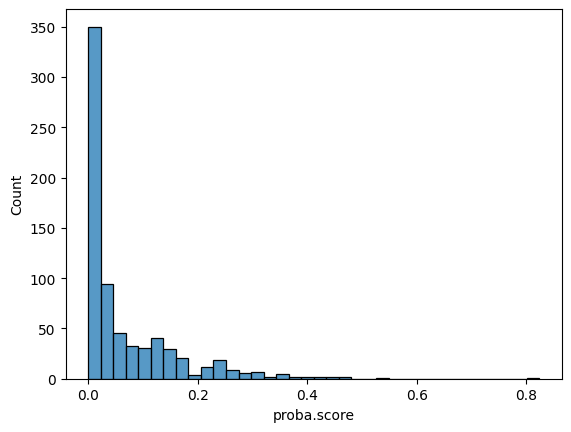

In [100]:
d = dev_baselines["baseline_no_ckpt_ft_train_no_ia3_template_0"].copy()
d["proba.score"] = d["log.score"].apply(np.exp)
sns.histplot(data=d, x="proba.score")

print(d.prediction.value_counts())
print(d.label.value_counts())

In [101]:
sns.boxplot(data=instance_baseline_corrs, y="basename", x="kendalltau")

ValueError: Could not interpret input 'basename'

In [102]:
system_baseline_corrs.sort_values("kendalltau", ascending=False).head()

,pearsonr,spearmanr,kendalltau,index
log.score,-0.1505,-0.2096,-0.1377,baseline_no_ckpt_ft_train_ia3_template_0
log.score,-0.3415,-0.3800,-0.2391,baseline_ia3_pretrained100k_ft_train_ia3_templ...


In [103]:
d = dev_baselines["baseline_no_ckpt_ft_train_no_ia3_template_7"].copy()
d["proba.scores_class_1"] = d["log.scores_class_1"].apply(np.exp)
sns.histplot(data=d, x="proba.scores_class_1", hue="label")

print(d.prediction.value_counts())
print(d.label.value_counts())

KeyError: 'log.scores_class_1'

In [105]:
sns.boxplot(data=system_baseline_corrs, y="basename", x="kendalltau")

ValueError: Could not interpret input 'basename'

In [106]:
sns.boxplot(data=system_baseline_corrs, y="eval_template", x="kendalltau")

ValueError: Could not interpret input 'eval_template'

In [111]:
metrics_reg["eval_template"] = metrics_reg["baseline"].apply(extract_template)
metrics_reg["basename"] = metrics_reg["baseline"].apply(extract_basename)
metrics_reg.tail()

,accuracy,digits_count,digits_pct,err_len,err_avg,mae_avg,mse_avg,err_std,mae_std,mse_std,baseline,eval_template,basename
40,0.0,2,0.002778,2,-19.000000,19.000000,461.000000,10.00000,10.000000,380.0000,baseline_template_4,4,baseline
41,0.0,1,0.001389,1,-29.000000,29.000000,841.000000,0.00000,0.000000,0.0000,baseline_template_5,5,baseline
42,0.0,0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,baseline_template_6,6,baseline
43,0.0,21,0.029167,21,-22.714286,32.142857,1272.428571,27.50436,15.468203,1463.8256,baseline_template_7,7,baseline
44,0.0,0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,baseline_template_8,8,baseline


<AxesSubplot:xlabel='accuracy', ylabel='basename'>

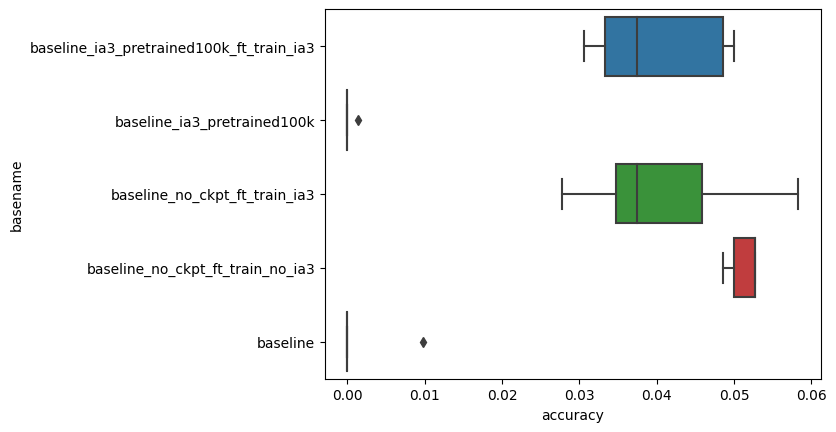

In [108]:
sns.boxplot(data=metrics_reg, y="basename", x="accuracy")

<AxesSubplot:xlabel='digits_count', ylabel='basename'>

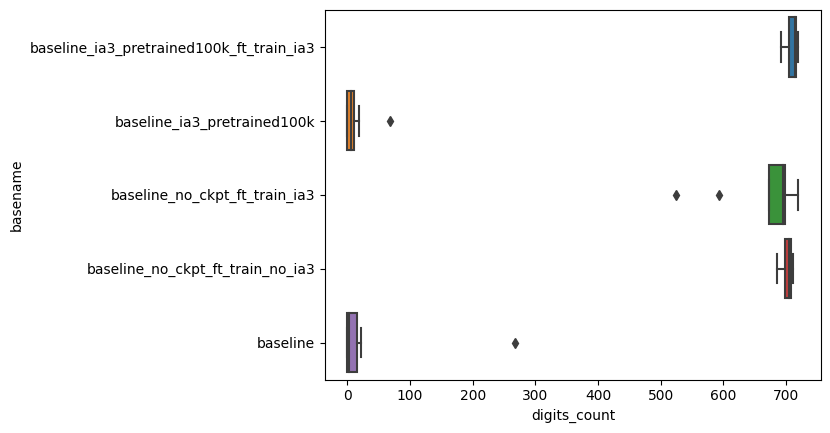

In [109]:
sns.boxplot(data=metrics_reg, y="basename", x="digits_count")